# Class 5: Model Evaluation 2 -- Cross-Validation for Model Selection

- The purpose of this notebook is to illustrate the use of **cross-validation for model selection**. Keep in mind that cross-validation is very commonly combined with hyperparameter tuning and model selection, particularly for *small datasets*.
- We will start with linear regression and logistic regression, but we will include many other examples of machine learning algorithms that we will study in detail during this course. Keep this notebook as a reference to come back to as we study further machine learning algorithms in future sessions.

# Part I


## Model selection for linear regression

For linear regression, we have two special methods for model selection:
- LassoCV: Lasso linear model with iterative fitting along a regularisation path. The best model is selected by cross-validation. 
- RidgeCV: Ridge regression with built-in cross-validation. By default, it performs efficient Leave-One-Out Cross-Validation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load diabetes dataset
X, y = load_diabetes(return_X_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardise
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std  = sc.transform(X_test)

# LassoCV
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_std, y_train)

y_pred_lasso = lasso.predict(X_test_std)
print("=== LassoCV ===")
print("Best alpha:", lasso.alpha_)
print("Test MSE :", mean_squared_error(y_test, y_pred_lasso))
print("Non-zero coefficients (out of 10 diabetes features):", np.sum(lasso.coef_ != 0))

# RidgeCV
alphas = np.logspace(-3, 3, 50)
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
ridge.fit(X_train_std, y_train)

y_pred_ridge = ridge.predict(X_test_std)
print("\n=== RidgeCV ===")
print("Best alpha:", ridge.alpha_)
print("Test MSE :", mean_squared_error(y_test, y_pred_ridge))


=== LassoCV ===
Best alpha: 1.6552151706972245
Test MSE : 2800.487334373644
Non-zero coefficients (out of 10 diabetes features): 7

=== RidgeCV ===
Best alpha: 1.151395399326447
Test MSE : 2891.204288709694


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


<p style="margin-bottom:2cm;"></p>

In general, two generic approaches to parameter search are provided in scikit-learn: for given values, `GridSearchCV` exhaustively considers all parameter combinations, while `RandomizedSearchCV` can sample a given number of candidates from a parameter space with a specified distribution.

## GridSearch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

- For hyperparameter tuning and model selection, `GridSearchCV` is really useful

### CV with grid search for logistic regression: binary classification

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Load data and split into training and test set
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

<p style="margin-bottom:5cm;"></p>

- Recall that feature scaling DOES matter for most machine learning algorithms, including logistic regression
- Moreover, it is compulsory if we do regularisation
- To avoid introducing bias, we have to compute the parameters for scaling (e.g., the mean and standard deviation in the context of z-score normalisation) on the training fold to scale the training AND test fold in a given iteration
- To make this more convenient, this is where scikit-learn's `Pipeline` class (or `make_pipeline` function) comes in handy, as the next cell demonstrates

In [4]:
# Pipeline: scale. Logistic regression (solver 'saga' supports L1 & L2)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(solver="saga", max_iter=10000, random_state=42))
])

# Hyperparameter grid
param_grid = {
    "logreg__C": np.logspace(-3, 3, 13),     # inverse of the regularisation strength: 0.001 ... 1000
    "logreg__penalty": ["l1", "l2"]
}

# CV + GridSearch (refit by best log loss)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring={"acc": "accuracy", "nll": "neg_log_loss"},
    refit="nll",                   # refit the best model by neg_log_loss
    n_jobs=-1,
    verbose=0
)

# Fit search
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV (neg log loss):", gs.best_score_)


Best params: {'logreg__C': 1.0, 'logreg__penalty': 'l2'}
Best CV (neg log loss): -0.07195748379524221


- Do these results ring a bell? Revisit the notebook `4. Model evaluation I - CLASS` and have a look at the figures in section 3.4.1. Are these results consistent with those?

In [5]:
# Print test score for each hyperparameter setting
for i in range(len(gs.cv_results_['mean_test_nll'])):
    print(gs.cv_results_['mean_test_nll'][i], gs.cv_results_['params'][i]) 

-0.6670210158312813 {'logreg__C': 0.001, 'logreg__penalty': 'l1'}
-0.38736577037874576 {'logreg__C': 0.001, 'logreg__penalty': 'l2'}
-0.6670344223711758 {'logreg__C': 0.0031622776601683794, 'logreg__penalty': 'l1'}
-0.2733808700629655 {'logreg__C': 0.0031622776601683794, 'logreg__penalty': 'l2'}
-0.4947513065316649 {'logreg__C': 0.01, 'logreg__penalty': 'l1'}
-0.1887713850503645 {'logreg__C': 0.01, 'logreg__penalty': 'l2'}
-0.24319589166392622 {'logreg__C': 0.03162277660168379, 'logreg__penalty': 'l1'}
-0.1326151333930135 {'logreg__C': 0.03162277660168379, 'logreg__penalty': 'l2'}
-0.14182329577661873 {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
-0.09829259610908811 {'logreg__C': 0.1, 'logreg__penalty': 'l2'}
-0.09847250208036974 {'logreg__C': 0.31622776601683794, 'logreg__penalty': 'l1'}
-0.07919034874007981 {'logreg__C': 0.31622776601683794, 'logreg__penalty': 'l2'}
-0.08348837406991108 {'logreg__C': 1.0, 'logreg__penalty': 'l1'}
-0.07195748379524221 {'logreg__C': 1.0, 'logreg__penalt

- We can summarise the results in a heatmap, but note that this only works if you have 1 or 2 hyperparameters to consider.

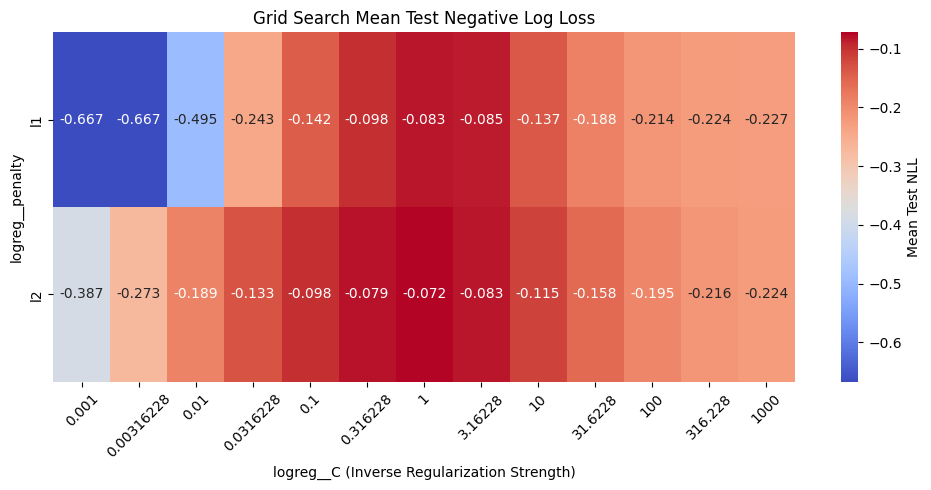

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Extract and format results
results = pd.DataFrame(gs.cv_results_)

# Convert 'param_logreg__C' to numeric if needed
results["param_logreg__C"] = results["param_logreg__C"].astype(float)

# Pivot table
pivot = results.pivot(index="param_logreg__penalty",
                      columns="param_logreg__C",
                      values="mean_test_nll").sort_index(axis=1)

# Plot
plt.figure(figsize=(10, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={"label": "Mean Test NLL"})
plt.title("Grid Search Mean Test Negative Log Loss")
plt.xlabel("logreg__C (Inverse Regularization Strength)")
plt.ylabel("logreg__penalty")

# Ensure tick labels show numeric C values in log order
plt.xticks(ticks=np.arange(len(pivot.columns)) + 0.5,
           labels=[f"{c:g}" for c in pivot.columns],
           rotation=45)

plt.tight_layout()
plt.show()


- After running `GridSearchCV`, we would fit a model with the best settings (hyperparameters on the whole training set. This corresponds to STEP 3 in the Model Selection process (look at class slides on model selection)
- By default, `GridSearchCV` already does this for us (unless, we set `refit=False`), so that we can evaluate the performance of the model on the test set. This corresponds to STEP 4 in the Model Selection process (look at class slides on model selection)

In [11]:
# Evaluate on held-out test set
best_model = gs.best_estimator_
p_test = best_model.predict_proba(X_test)[:, 1]
y_pred = (p_test >= 0.5).astype(int)

print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print("Test log loss:", log_loss(y_test, p_test))


Test accuracy: 0.9824561403508771
Test log loss: 0.0778738435718277


### CV with grid search for decision trees: multiclass classification

- Now we consider a very important classifier in this course that we will study in future lectures: decision trees. Let's do multiclass classification with the Iris dataset, which has three classes (['setosa' 'versicolor' 'virginica']).
- In practice, we will use `DecisionTreeClassifier` as a blackbox classifier with two hyperparameters (the maximum tree depth and the criterion to build the decision tree).

In [21]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


X, y = iris_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15, 
                                                    shuffle=True, stratify=y)

In [22]:
from sklearn.model_selection import GridSearchCV

# Two hyperparameters: max_depth, criterion
# None means no restriction on maximum depth
param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  refit=True, # default value
                  cv=10,      # k-fold cross-validation, stratified because we have a classifier, it will use accuracy to find the best hyperparameters
                  n_jobs=None) # no multiple operations in parallel

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100)) # accuracy
print('Best Params:', gs.best_params_)

Best Accuracy: 96.09%
Best Params: {'criterion': 'gini', 'max_depth': 3}


In [24]:
# All the results are stored in a dictionary you can inspect
gs.cv_results_

{'mean_fit_time': array([0.00063491, 0.0006026 , 0.00053463, 0.00055177, 0.00054078,
        0.00054107, 0.00046957, 0.00051398, 0.00052588, 0.0004607 ,
        0.00063043, 0.00046043, 0.00062175, 0.00046079]),
 'std_fit_time': array([3.30515524e-04, 3.29610547e-04, 2.65526509e-04, 2.46291540e-04,
        2.55487124e-04, 2.45067724e-04, 2.50044717e-05, 2.52237996e-04,
        2.58684291e-04, 2.00592221e-05, 3.20768746e-04, 9.57291419e-06,
        3.24930286e-04, 1.42126472e-05]),
 'mean_score_time': array([0.00031514, 0.00024269, 0.00025878, 0.00025282, 0.0003315 ,
        0.00023935, 0.0003267 , 0.00032771, 0.00023727, 0.00032408,
        0.0002429 , 0.00032511, 0.00023766, 0.00023656]),
 'std_score_time': array([1.11873091e-04, 2.74037137e-05, 5.36457909e-05, 3.41630114e-05,
        2.50160976e-04, 1.75950488e-05, 2.51254522e-04, 2.49925663e-04,
        1.85031251e-05, 2.50367573e-04, 1.68617063e-05, 2.53965261e-04,
        1.35805701e-05, 1.27890179e-05]),
 'param_criterion': masked

In [25]:
# Print test score for each hyperparameter setting
for i in range(len(gs.cv_results_['mean_test_score'])):
    print(gs.cv_results_['mean_test_score'][i], gs.cv_results_['params'][i]) 

0.653846153846154 {'criterion': 'gini', 'max_depth': 1}
0.9121794871794873 {'criterion': 'gini', 'max_depth': 2}
0.9608974358974359 {'criterion': 'gini', 'max_depth': 3}
0.951923076923077 {'criterion': 'gini', 'max_depth': 4}
0.9602564102564102 {'criterion': 'gini', 'max_depth': 5}
0.9602564102564102 {'criterion': 'gini', 'max_depth': 6}
0.9602564102564102 {'criterion': 'gini', 'max_depth': None}
0.653846153846154 {'criterion': 'entropy', 'max_depth': 1}
0.9121794871794873 {'criterion': 'entropy', 'max_depth': 2}
0.9608974358974359 {'criterion': 'entropy', 'max_depth': 3}
0.9365384615384617 {'criterion': 'entropy', 'max_depth': 4}
0.9448717948717948 {'criterion': 'entropy', 'max_depth': 5}
0.9525641025641025 {'criterion': 'entropy', 'max_depth': 6}
0.9525641025641025 {'criterion': 'entropy', 'max_depth': None}


- We can summarise the results in a heatmap, but note that this only works if you have 1 or 2 hyperparameters to consider.

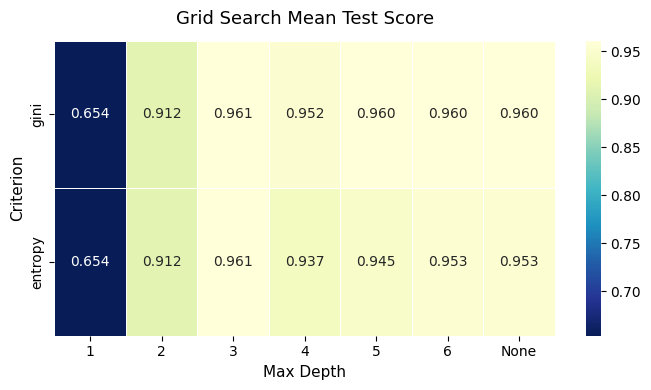

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example grid (same as before)
grid = np.zeros((2, 7))
grid[0, :] = gs.cv_results_['mean_test_score'][:7]
grid[1, :] = gs.cv_results_['mean_test_score'][7:]

# Convert grid into DataFrame for seaborn
df = pd.DataFrame(
    grid,
    index=['gini', 'entropy'],
    columns=[1, 2, 3, 4, 5, 6, "None"]
)

# Create figure
plt.figure(figsize=(7, 4))

# Seaborn heatmap
sns.heatmap(df, cmap="YlGnBu_r", annot=True, fmt=".3f", linewidths=0.5, linecolor="white")

# Titles and labels
plt.title("Grid Search Mean Test Score", fontsize=13, pad=12)
plt.xlabel("Max Depth", fontsize=11)
plt.ylabel("Criterion", fontsize=11)

# Improve layout
plt.tight_layout()
plt.show()


- After running `GridSearchCV`, we would fit a model with the best settings (hyperparameters on the whole training set. This corresponds to STEP 3 in the Model Selection process (look at class slides on model selection)
- By default, `GridSearchCV` already does this for us (unless, we set `refit=False`), so that we can evaluate the performance of the model on the test set. This corresponds to STEP 4 in the Model Selection process (look at class slides on model selection)

In [10]:
# Best model (Gini is not printed because it's the default parameter). This is already our best model fit to the whole training set 
gs.best_estimator_

DecisionTreeClassifier(max_depth=3, random_state=123)

In [8]:
# gs.best_estimator_.fit(X_train, y_train)
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Accuracy: 95.65%


<p style="margin-bottom:5cm;"></p>


# Part II

The second part of this notebook is devoted to ML algorithms that we will introduce in the next lectures.
We will keep it aside for now. We wil visit this part as we move along with the course.

### CV with grid search for K-nearest neighbour classifier

- Note that feature scaling is unnecessary when we are using decision trees; however, it DOES matter in most other learning algorithms.
- To avoid introducing bias, we have to compute the parameters for scaling (e.g., the mean and standard deviation in the context of z-score normalisation) on the training fold to scale the training AND test fold in a given iteration.
- To make this more convenient, this is where scikit-learn's `Pipeline` class (or `make_pipeline` function) comes in handy, as the next cell demonstrates.

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


pipe = make_pipeline(StandardScaler(), 
                     KNeighborsClassifier())

# since we're using a pipeline, we have to prepend each parameter's name in the grid 
# with the name of the model in the pipe: kneighborsclassifier corresponds to KNeighborsClassifier
param_grid = [{'kneighborsclassifier__n_neighbors': list(range(1, 16)),
               'kneighborsclassifier__p': [1, 2]}] # parameters for the Minkowsk distance: 1 for the Manhattan distance, 2 for Euclidean


gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  n_jobs=-1,
                  cv=10) # k-fold cross-validation with k=10

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)
print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 96.03%
Best Params: {'kneighborsclassifier__n_neighbors': 11, 'kneighborsclassifier__p': 2}
Accuracy: 91.30%


<br>
<br>
<br>
<br>

## Randomised Search

- While using a grid of parameter settings is currently the most widely used method for parameter optimisation, other search methods have more favourable properties.
- `RandomizedSearchCV` implements a randomised search over parameters, where each setting is sampled from a distribution (discrete or continuous) over possible parameter values instead of doing an exhaustive search.
- Instead of running all combinations exhaustively like in GridSearch, a budget is specified (`n_iter` specifies the number of candidates to evaluate)

### ParamSampler

- To explain these concepts, let's take a look at the `ParamSampler` first, which is used under the hood of the `RandomizedSearchCV`; it will help us building some intuition.

As we can see in the example below, lists are also supported; they will behave like gridsearch

In [37]:
from sklearn.model_selection import ParameterSampler


d = {'parameter 1': [1, 2, 3], 
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

list(ps)

/home/jar/mypython/lib/python3.12/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[{'parameter 2': 'a', 'parameter 1': 1},
 {'parameter 2': 'b', 'parameter 1': 1},
 {'parameter 2': 'a', 'parameter 1': 2},
 {'parameter 2': 'b', 'parameter 1': 2},
 {'parameter 2': 'a', 'parameter 1': 3},
 {'parameter 2': 'b', 'parameter 1': 3}]

- We can define probability distributions using SciPy's selection of distributions (https://docs.scipy.org/doc/scipy/reference/stats.html).

- Consider a discrete random uniform distribution for parameter 1 (note that in this case, there is a sampling with replacement from the distribution)

In [38]:
import scipy.stats

d = {'parameter 1': scipy.stats.randint(low=1, high=4), # integer between 1-3
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

list(ps)

[{'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 3, 'parameter 2': 'a'},
 {'parameter 1': 1, 'parameter 2': 'a'},
 {'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 3, 'parameter 2': 'b'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 2, 'parameter 2': 'a'},
 {'parameter 1': 3, 'parameter 2': 'a'}]

- below is an example for sampling from a uniform continuous distribution:

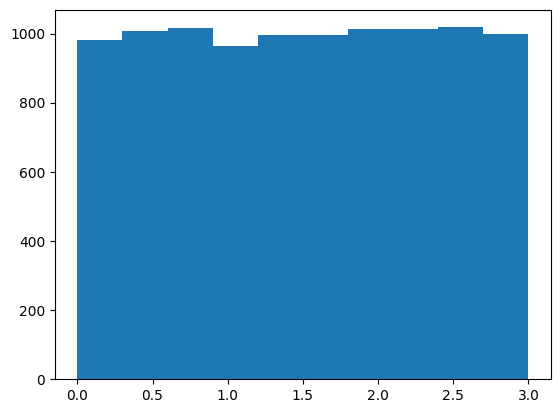

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.hist(scipy.stats.uniform(loc=0, scale=3).rvs(10000))
plt.show()

In [40]:
d = {'parameter 1': scipy.stats.uniform(loc=0, scale=3), # float between 1-3
     'parameter 2': ['a', 'b']}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

list(ps)

[{'parameter 1': 2.089407556793585, 'parameter 2': 'a'},
 {'parameter 1': 1.285412778560477, 'parameter 2': 'a'},
 {'parameter 1': 1.6539443072486737, 'parameter 2': 'b'},
 {'parameter 1': 1.473356800297792, 'parameter 2': 'b'},
 {'parameter 1': 2.9422925951538463, 'parameter 2': 'a'},
 {'parameter 1': 1.7390828910678304, 'parameter 2': 'b'},
 {'parameter 1': 1.1763525545824516, 'parameter 2': 'a'},
 {'parameter 1': 1.8819510280128502, 'parameter 2': 'b'},
 {'parameter 1': 1.3157167340388733, 'parameter 2': 'b'},
 {'parameter 1': 2.084265531555807, 'parameter 2': 'a'}]

<br>
<br>
<br>
<br>

### RandomizedSeachCV example: Gradient boosting classifier (ensemble method)

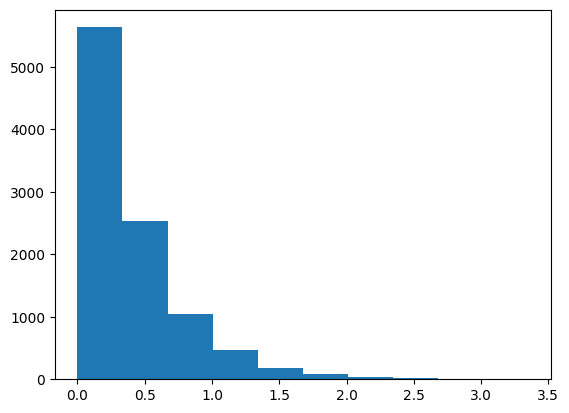

In [41]:
# Exponential distribution to sample the learning rate
plt.hist(scipy.stats.expon(scale=0.4).rvs(10000))
plt.show()

In [42]:
#from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [43]:
gbm = HistGradientBoostingClassifier(random_state=123)

d = {'learning_rate': scipy.stats.expon(scale=0.4),
     'max_depth': scipy.stats.randint(low=3, high=10),
     'l2_regularization': scipy.stats.uniform(loc=0, scale=1)}

rcv = RandomizedSearchCV(estimator=gbm,
                         param_distributions=d, 
                         n_iter=200,
                         cv=10, # stratified k-fold cross-validation because our estimator is a classifier
                         refit=True,
                         random_state=123,
                         n_jobs=-1)

rcv.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (rcv.best_score_*100))
print('Best Params:', rcv.best_params_)

Best Accuracy: 96.73%
Best Params: {'l2_regularization': 0.7770044388897804, 'learning_rate': 0.011352363969357031, 'max_depth': 5}
